In [1]:
import torch
import torch.optim as optim
import importlib
import training
importlib.reload(training)
from training import Trainer
import models
importlib.reload(models)

import dataloaders
importlib.reload(dataloaders)
from dataloaders import get_darcy_dataloader_transformers

from models import Generator, Discriminator
import matplotlib.pyplot as plt
import numpy as np
import yaml
import wandb
from tqdm.auto import tqdm

from scipy.interpolate import RectBivariateSpline


plt.style.use('ggplot')

In [2]:
run_name = 'good-dust-1'
save_dir='trained_models/'+run_name
generator_path=save_dir+'/generator.pkl'
discriminator_path = save_dir+'/discriminator.pkl'

wandb_config_path = "wandb/run-20231004_115939-3bky6eaf/files/config.yaml"

with open(wandb_config_path,'r') as f:
    configs=yaml.safe_load(f)

configs = {
    key: value['value'] if type(value)==dict else value for key,value in configs.items()
}


In [3]:
generator=torch.load(generator_path)
generator.to('cpu')
discriminator = torch.load(discriminator_path)

In [4]:
data_loader,pca_X,normalizer_y = get_darcy_dataloader_transformers(
    batch_size=configs['batch_size'],
    latent_dim=configs['latent_dim'],
    num_datapoints=configs['num_datapoints'],
    num_observation_grid=configs['grid_num_observed'],
    noise_level_y_observed=configs['y_noise_level'],
    shuffle = False,
    path_prefix = 'data_old_wider_bandwidth'
    )

Resampling observation arrays


  0%|          | 0/80000 [00:00<?, ?it/s]

Rough Ratio SDnoise/SDsignal:
0.023045213676114295


In [7]:
batch_size=configs['batch_size']
latent_dim=configs['latent_dim']
num_datapoints=configs['num_datapoints']
num_observation_grid=configs['grid_num_observed']
noise_level_y_observed=configs['y_noise_level']


y_observed_raw=np.load("data_old_wider_bandwidth/X_observed.npy")[-20:]
x_fields=np.log(np.load("data_old_wider_bandwidth/true_permeability_fields.npy"))[-20:]
K_prior=np.load("data_old_wider_bandwidth/kernel_matrix_prior.npy")
pca=pca_X

#subset data for x here
x_pca=pca.transform(x_fields.reshape(-1,40*40))
x_data=torch.tensor(x_pca,dtype=torch.float)
num_observation_grid = 8

obs_grid=np.linspace(0,1,num_observation_grid+2)[1:-1]
original_sampling_grid=np.linspace(0,1,y_observed_raw.shape[1])
print("Resampling observation arrays")
y_observed=np.array(
    [
        RectBivariateSpline(
            original_sampling_grid,original_sampling_grid,y
            )(obs_grid,obs_grid).reshape(num_observation_grid**2)
        for y in tqdm(y_observed_raw)#Subset data for y here
    ]
)
# Add a uniform noise first before centering/normalizing
#y_observed = y_observed + noise_level_y_observed*np.random.standard_normal(size = y_observed.shape)
y_Normalizer=normalizer_y
y_normalized = y_Normalizer.transform(y_observed)
y_data=torch.tensor(y_normalized,dtype=torch.float)
print("Rough Ratio SDnoise/SDsignal:")
print(np.mean(noise_level_y_observed/y_Normalizer.std))


Resampling observation arrays


  0%|          | 0/20 [00:00<?, ?it/s]

Rough Ratio SDnoise/SDsignal:
0.023045213676114295


In [8]:
def plot_pair(posterior_mean_field,true_field_PCA,title1='Posterior Mean',title2='True'):
    from matplotlib.colors import Normalize
    import matplotlib.cm as cm

    fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,10))
    cmap=cm.get_cmap('viridis')


    lower=np.min(np.minimum(posterior_mean_field,true_field_PCA))
    upper=np.max(np.maximum(posterior_mean_field,true_field_PCA))
    normalizer=Normalize(lower,upper)

    im=cm.ScalarMappable(norm=normalizer)
    for ax,image,title in zip(axes.flat,[posterior_mean_field,true_field_PCA],[title1,title2]):
        ax.imshow(image,cmap=cmap,norm=normalizer)
        ax.set_title(title)
    fig.colorbar(im, ax=axes.ravel().tolist(),shrink=0.5)
    plt.show()

In [9]:
ind=-4

cond = y_data[ind:ind+1]
true=x_data[ind:ind+1]
cond_multi=torch.cat([cond]*100000)
input_concatenated=generator.sample_concat_latent(cond_multi)
generated = generator(input_concatenated).detach().numpy()
generated_mean=np.mean(generated,axis=0)
posterior_mean_field = pca_X.inverse_transform(generated_mean).reshape(40,40)
true_field_PCA=pca_X.inverse_transform(true.detach().numpy())[0].reshape(40,40)

In [10]:
true_permeability = x_fields[-4]

In [12]:
samples = pca_X.inverse_transform(generated)

In [13]:
np.save("MGAN_samples_wide_bw.npy",samples)

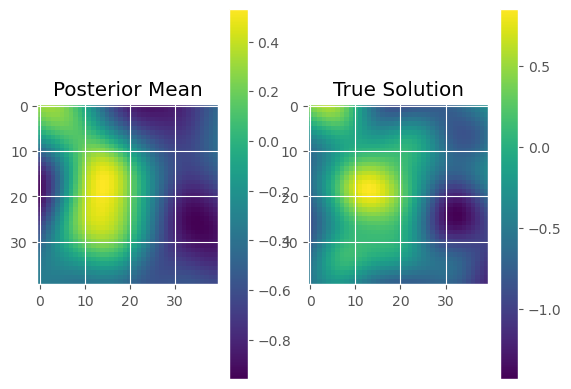

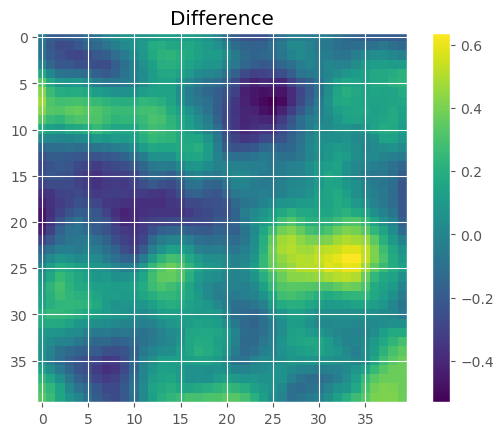

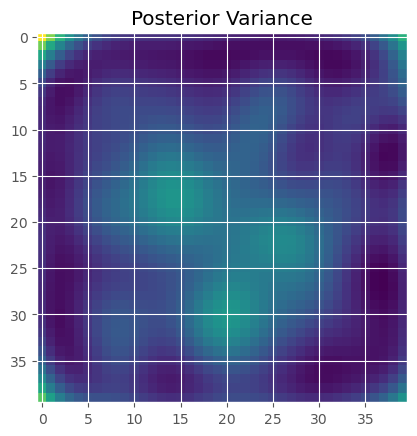

In [20]:
posterior_mean = np.mean(samples,axis=0).reshape(40,40)

plt.subplot(1,2,1)
plt.title("Posterior Mean")
plt.imshow(posterior_mean)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True Solution")
plt.imshow(true_field_PCA)
plt.colorbar()
plt.show()

plt.title("Difference")
plt.imshow(posterior_mean - true_permeability)
plt.colorbar()
plt.show()

plt.title("Posterior Variance")
plt.imshow(np.var(samples,axis=0).reshape(40,40)+np.diag(pca_X.uncertainty_mat).reshape(40,40))
plt.show()

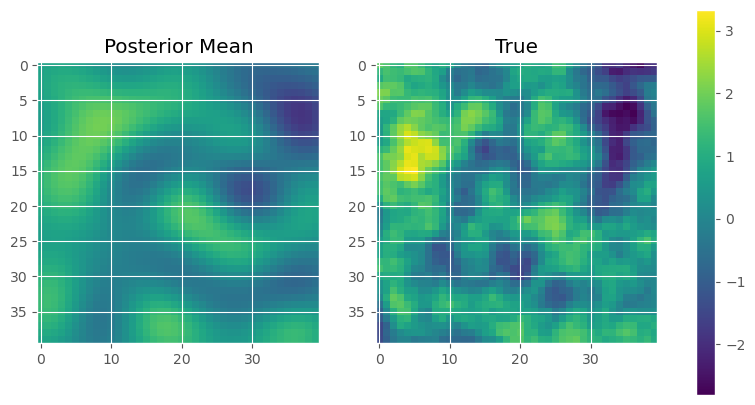

In [107]:
plot_pair(posterior_mean_field,true_field)

In [12]:
posterior_variance_field = np.var(pca_X.inverse_transform(generated),axis=0).reshape(40,40)

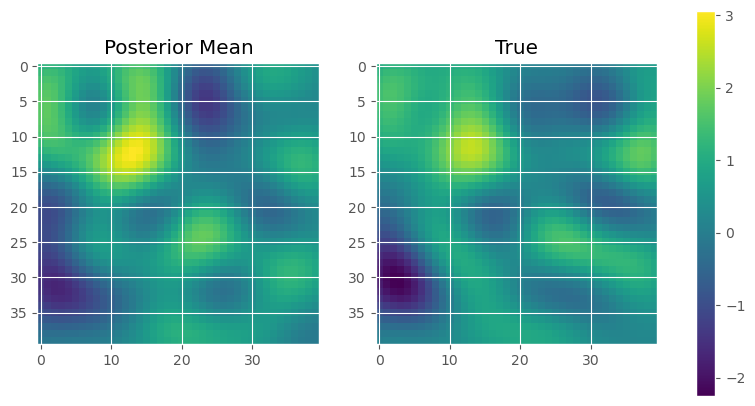

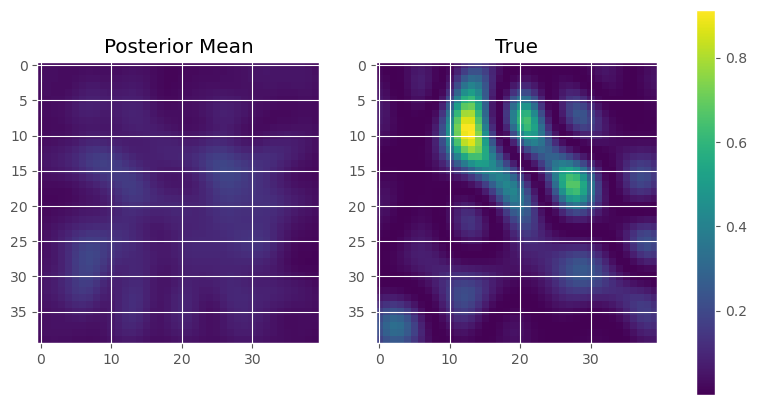

In [55]:
plot_pair(posterior_variance_field,(posterior_mean_field-true_field_PCA)**2)

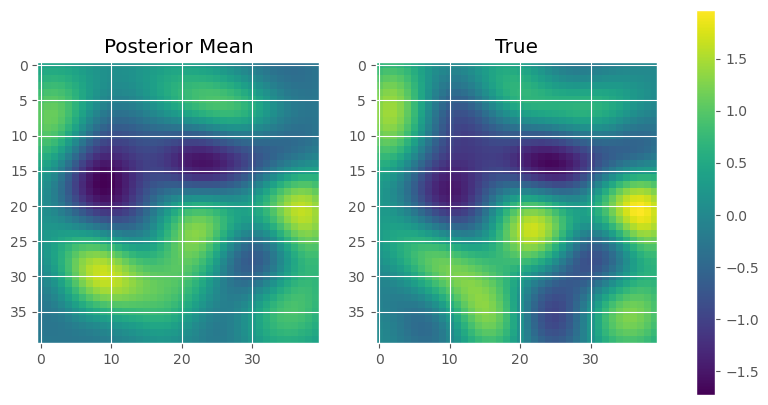

In [23]:
from scipy.interpolate import RectBivariateSpline  

num_observation_grid=9

y_observed_test_raw=np.load("data/test_X_observed.npy")
test_x_fields=np.log(np.load("data/test_fields.npy"))

#subset data for x here
x_pca=pca_X.transform(test_x_fields.reshape(-1,40*40))
x_data=torch.tensor(x_pca,dtype=torch.float)

obs_grid=np.linspace(0,1,num_observation_grid+2)[1:-1]
original_sampling_grid=np.linspace(0,1,y_observed_test_raw.shape[1])


print("Resampling observation arrays")
y_observed=np.array(
    [
        RectBivariateSpline(
            original_sampling_grid,original_sampling_grid,y
            )(obs_grid,obs_grid).reshape(num_observation_grid**2)
        for y in tqdm(y_observed_test_raw)#Subset data for y here
    ]
)
y_normalized = normalizer_y.transform(y_observed)
y_data=torch.tensor(y_normalized,dtype=torch.float)

Resampling observation arrays


  0%|          | 0/9 [00:00<?, ?it/s]

In [24]:
def plot_triple(posterior_mean_field,posterior_variance,true_field_PCA):
    from matplotlib.colors import Normalize
    import matplotlib.cm as cm

    fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(10,10))
    cmap=cm.get_cmap('viridis')


    lower=np.min(np.array([posterior_mean_field,posterior_variance,true_field_PCA]))
    upper=np.min(np.array([posterior_mean_field,posterior_variance,true_field_PCA]))
    normalizer=Normalize(lower,upper)

    #im=cm.ScalarMappable(norm=normalizer)
    for ax,image,title in zip(
            axes.flat,
            [posterior_mean_field,posterior_variance,true_field_PCA],
            ['Posterior Mean','Posterior Variance','PCA True Field']
            ):
        ax.imshow(image,cmap=cmap)
        ax.set_title(title)
        #fig.colorbar(ax,shrink=0.5)
    plt.show()

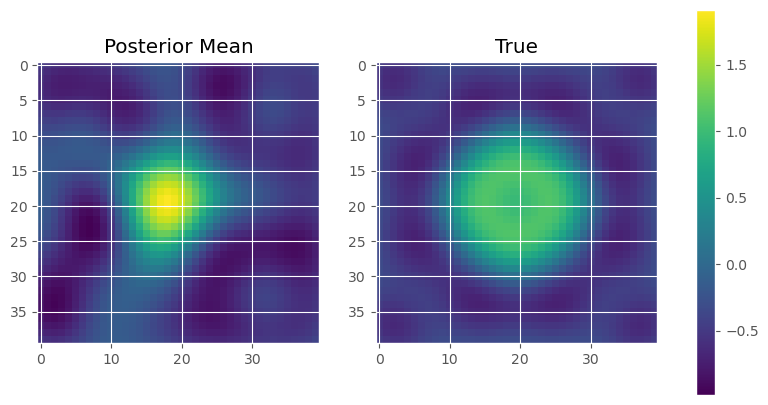

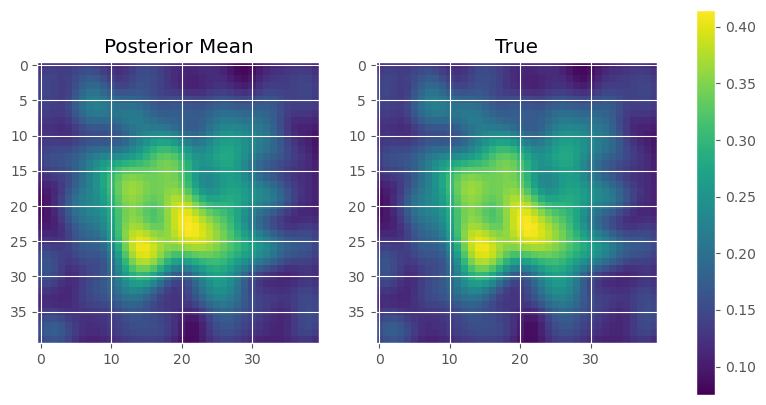

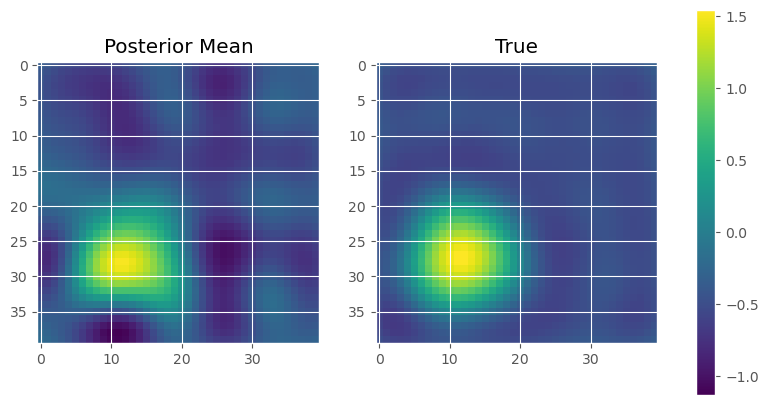

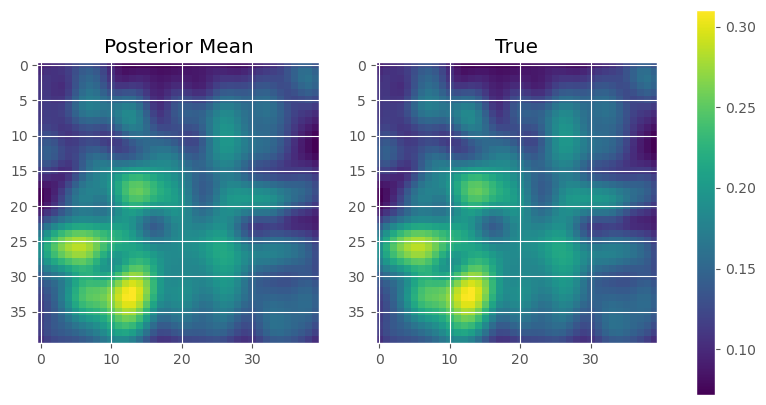

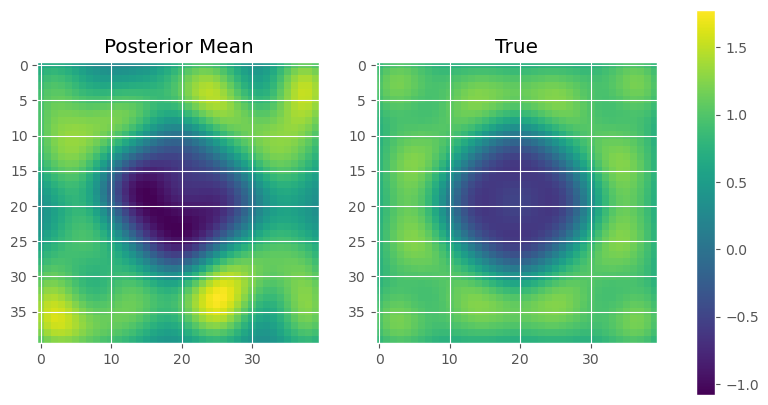

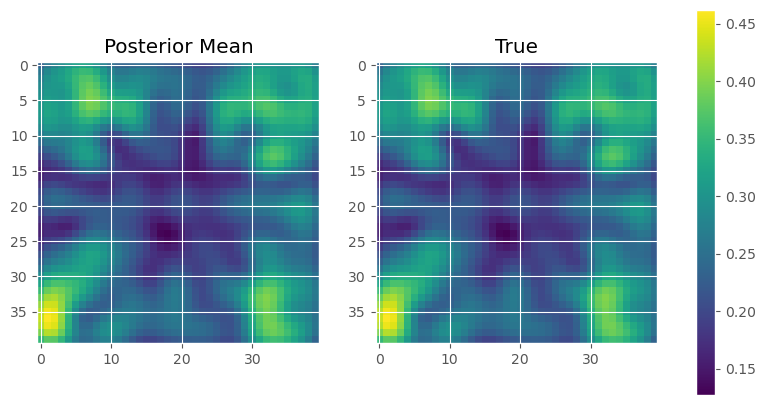

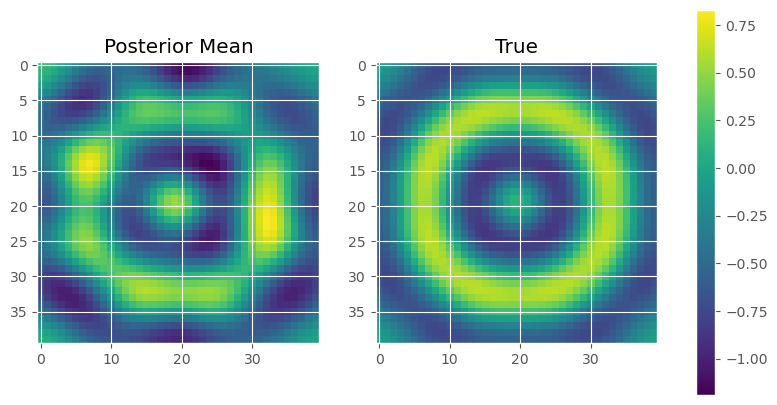

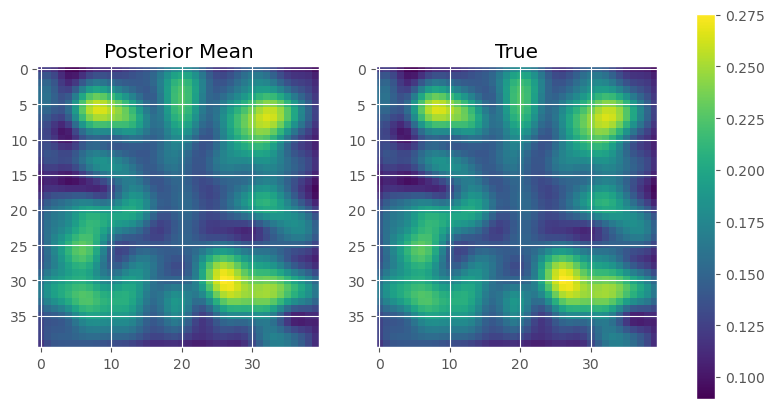

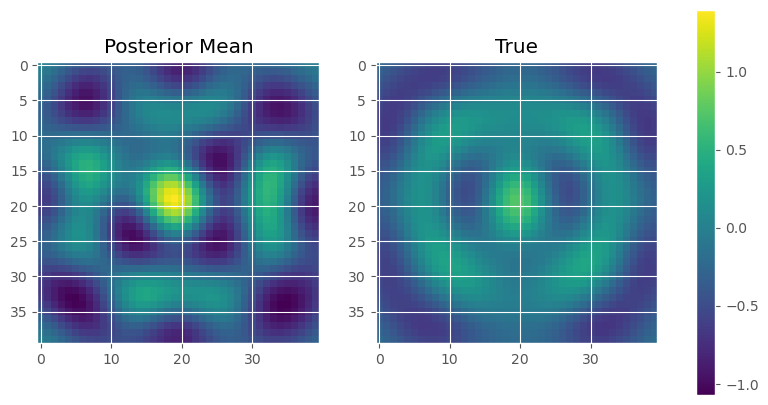

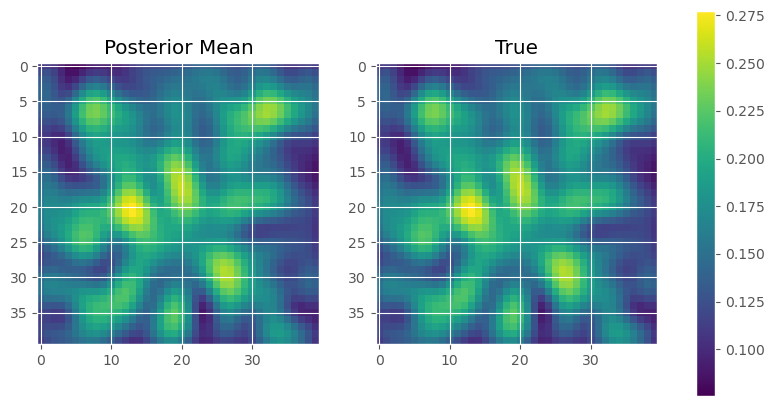

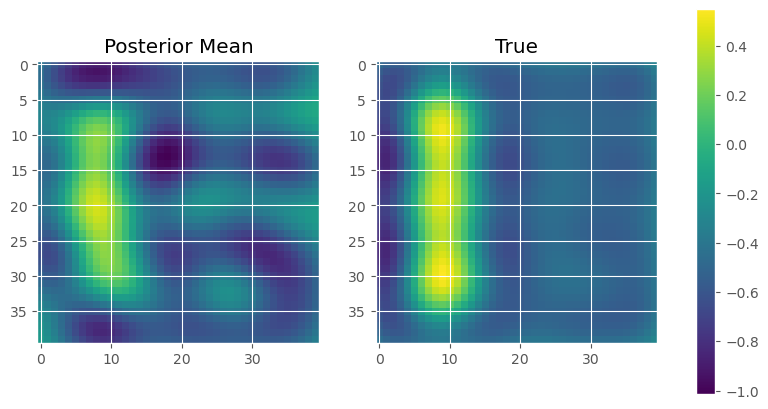

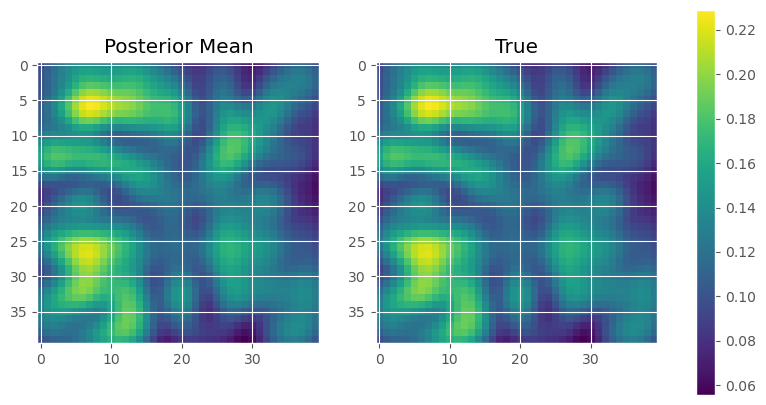

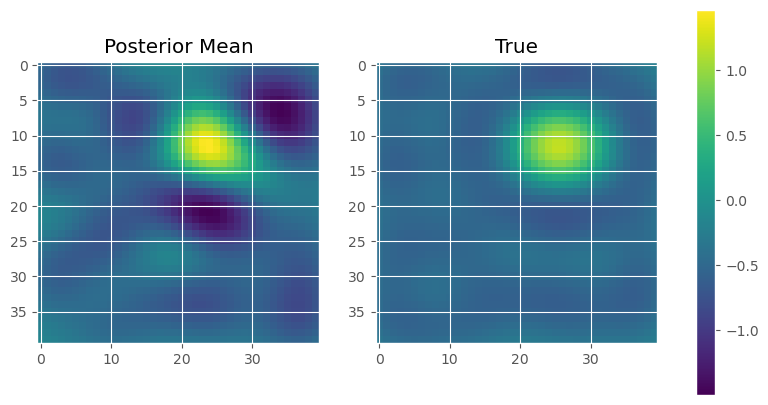

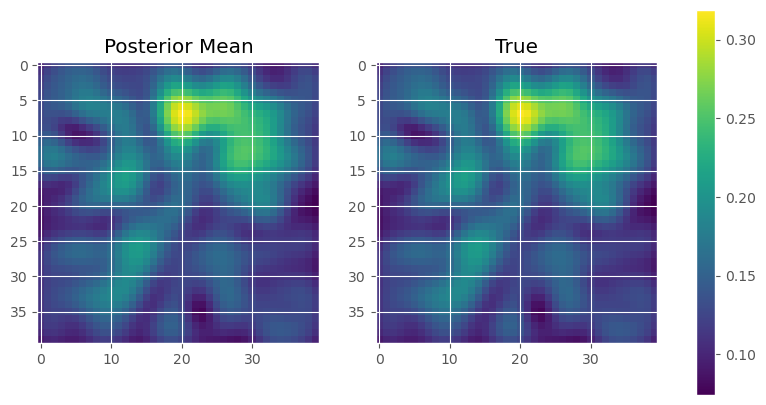

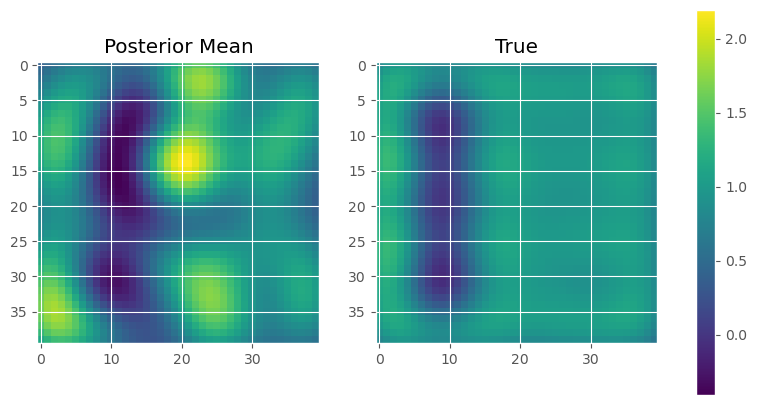

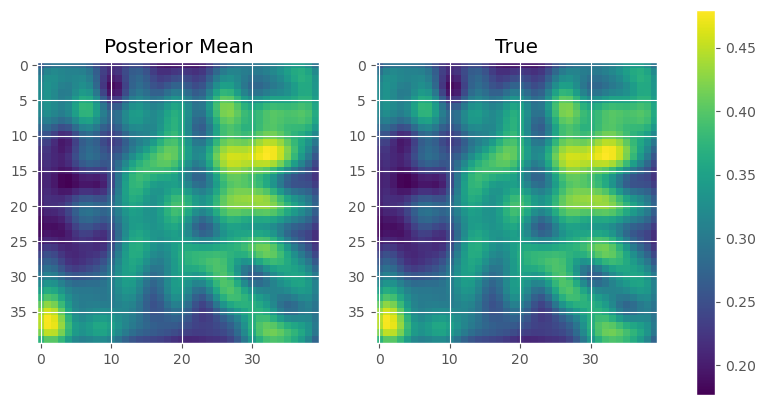

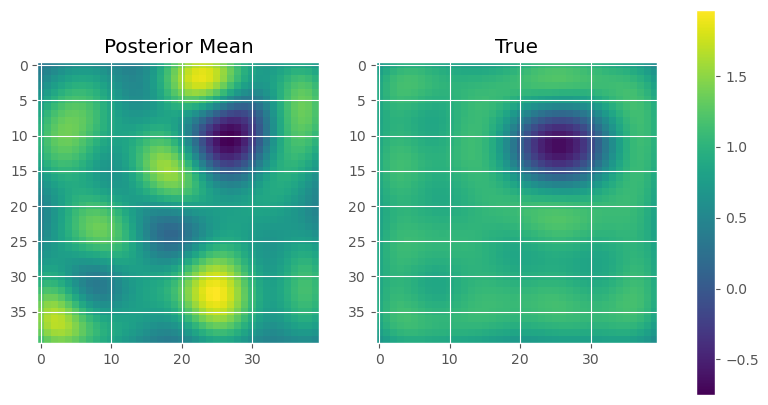

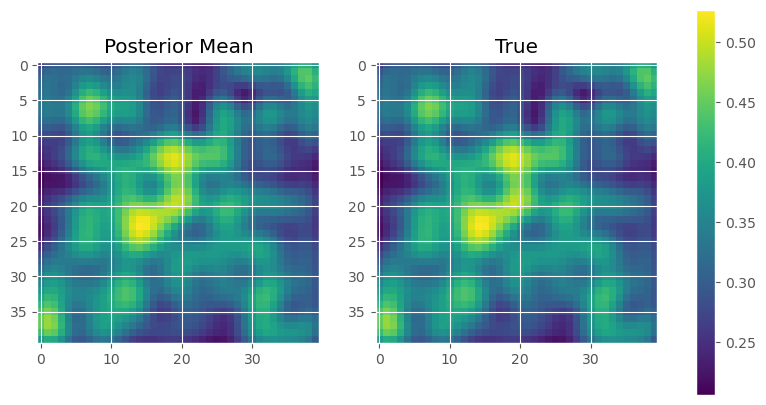

In [37]:
for ind in range(len(y_data)):
    cond,true=y_data[ind:ind+1],x_data[ind:ind+1]
    cond_multi=torch.cat([cond]*800)
    input_concatenated=generator.sample_concat_latent(cond_multi)
    generated = generator(input_concatenated).detach().numpy()
    generated_mean=np.mean(generated,axis=0)

    posterior_mean_field = pca_X.inverse_transform(generated_mean).reshape(40,40)

    posterior_variance_field = np.var(pca_X.inverse_transform(generated),axis=0).reshape(40,40)

    true_field_PCA_pca=pca_X.inverse_transform(true.detach().numpy())[0].reshape(40,40)

    true_field_PCA_raw=test_x_fields[ind]
    
    plot_pair(posterior_mean_field,true_field_PCA_pca)
    plot_pair(np.sqrt(posterior_variance_field),np.sqrt(posterior_variance_field))